In [1]:
from torchvision import transforms
from PIL import Image
import os
from torchvision.transforms import v2
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2

from tqdm import tqdm

import torch
import torchvision.transforms as T
import random
from sklearn.metrics import f1_score
import glob

# from Datasets import DATASET_REGISTRY

from skimage.feature import peak_local_max
from skimage import img_as_float
from scipy import ndimage as ndi

from segment_anything import sam_model_registry, SamPredictor

In [2]:
# Path to your local clone of the repo
REPO_DIR = "dinov3"

# Path to the downloaded checkpoint
CHECKPOINT_PATH = "dinov3_vits16_pretrain_lvd1689m-08c60483.pth"

# Load the model
model = torch.hub.load(REPO_DIR, 'dinov3_vits16', source='local', weights=CHECKPOINT_PATH)

model.eval()
print("Model loaded successfully!")

Model loaded successfully!


In [3]:
def make_transform(resize_size: int = 256):
    to_tensor = v2.ToImage()
    resize = v2.Resize((resize_size, resize_size), antialias=True)
    to_float = v2.ToDtype(torch.float32, scale=True)
    normalize = v2.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225),
    )
    return v2.Compose([to_tensor, resize, to_float, normalize])

pre_process = make_transform(resize_size = 256) #Could change size if we want


# SAM functions
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   



class Calculate_Anomaly_And_Mask:
    """
    Does anomaly score calculation, and mask segnemtation(ish)
    Inputs:
    Model - Whatever pretrained torch model that we are currently using (only really works for DinoV3 so far.)
    Training_Data - All the images that we use for "training" which in this case is just feature extraction.
    Test_Data - All the pictures which are different/anomalous in some respect, and also the normal pictures which we can compare with.
    """
    
    def __init__(self, model, TrainData, TestData, optional_param=None, rescale_training=False, rescale_test = False, rescale_factor=1.0):
        """
        Can also print some segmentation maps for visual inspection.
        """
        # Instance variables
        self.model = model
        self.TrainData = TrainData
        self.TestData = TestData
        self.optional_param = optional_param
        
        # Computed/internal variables
        self._private_var = None
        self.result = None
        self.G_cls_Tokens_Train = None
        self.G_cls_Tokens_Test = None
        self.P_cls_Tokens_Test = None
        self.N = None
        self.similarity_mode = "cosine"
        self.Anomaly_Scores = None
        # user settings
        self.rescale_training = rescale_training
        self.rescale_factor = rescale_factor
        self.rescale_test = rescale_test
        
    def Get_cls_Tokens_Global(self, Data):
        """
        This metod uses the model to extract global cls tokens.
        
        Parameters:
        -----------
        Data : PIL loaded Images in a list format, where we can loop over and extract tokens (and save them in another list ;P)
            
            
        Returns:
        --------
        List of tensors with cls_tokens.
        """
        cls_tokens = [] #Preallocate a list

        self.model.eval()
        with torch.no_grad():
            for img in Data:
                #Preprocess the image
                img_tensor = pre_process(img).unsqueeze(0)
                #Get features from the model
                features_dict = self.model.forward_features(img_tensor)
                #Get global cls features
                cls = features_dict["x_norm_clstoken"]  # shape [1, C]
                #Append to the list.
                cls_tokens.append(cls.squeeze(0))  # → shape [C]
        return cls_tokens
    
    def Get_cls_Tokens_Patch(self, Data):
        """
        Here we get the patch level cls tokens from the images, and agian save them in a list.

        """
        Patch_Tokens = []
        self.model.eval()
        with torch.no_grad():
            for img in Data:
                #Preprocess the image
                img_tensor = pre_process(img).unsqueeze(0)
                #Get features from the model
                features_dict = self.model.forward_features(img_tensor)
                #Get global cls features
                Patch = features_dict["x_norm_patchtokens"]  # shape [1, C]
                #Append to the list.
                Patch_Tokens.append(Patch.squeeze(0))  # → shape [C]
        # print(f'Patch token size: {np.array(Patch_Tokens).shape}')

        return Patch_Tokens
    
    def Get_Consine_Simlilarity(self, Patch_cls, Global_cls):
        """
        This function calculates the consine similarity between global cls tokens from an image, and the patch level embeddings from an image.
        """
        sim = F.cosine_similarity(Patch_cls, Global_cls.unsqueeze(0), dim=-1)

        return sim
    
    def Get_Cosine_Simlilarity_pp(self, Patch_cls1, Patch_cls2):
        sim = F.cosine_similarity(Patch_cls1, Patch_cls2, dim = -1)

        return sim
        

    def compute_similarity(self, x, y): #Default is cosine. This is just a more general version hehe.
        mode = self.similarity_mode
        if mode == "cosine":
            return F.cosine_similarity(x, y, dim=-1)
        elif mode == "dot":
            return (x * y).sum(dim=-1)
        elif mode == "l2":
            return torch.norm(x - y, dim=-1)
        elif mode == "mahalanobis":
            return self.compute_mahalanobis(x, y)
        else:
            raise ValueError(f"Unknown similarity type: {mode}")

    def UpsampleImage(self, Image):
        # 5. Upsample from 16×16 to 256×256 using PyTorch
        heatmap_up = F.interpolate(
            Image.unsqueeze(0).unsqueeze(0),  
            size=(256, 256),
            mode="bicubic",
            align_corners=False
        )[0, 0].cpu().numpy()
        return heatmap_up
    
    def UpsampleImage_By_Amount(self, img_tensor, amount):
        """
        img_tensor: torch.tensor (H,W) or (H,W,3)
        amount: float scaling factor
        """
        if img_tensor.ndim == 3: 
            img_tensor = img_tensor.permute(2,0,1)  # → (C,H,W)

        c, h, w = (img_tensor.shape if img_tensor.ndim == 3 
                else (1,) + tuple(img_tensor.shape))

        new_h = int(h * amount)
        new_w = int(w * amount)

        img_tensor = img_tensor.unsqueeze(0)  # → (1,C,H,W)

        out = F.interpolate(
            img_tensor,
            size=(new_h, new_w),
            mode="bicubic",
            align_corners=False
        )[0]  # → (C, new_h, new_w)

        if c == 1:
            out = out[0]
        else:
            out = out.permute(1,2,0)  # → (new_h,new_w,3)

        return out.cpu().numpy()
    

    def Rescale_Training_Data(self, scale_factor: float):
        """
        Rescales all training images by a user-specified factor.
        Uses UpsampleImage_By_Amount to do the resizing.

        scale_factor > 1  → upsample
        scale_factor < 1  → downsample
        """

        if scale_factor == 1.0:
            # Nothing to do
            return

        # print(f"[INFO] Rescaling all training images by factor {scale_factor} ...")

        new_train = []
        for img in self.TrainData:
            arr = np.asarray(img)                # PIL -> numpy array
            tensor = torch.from_numpy(arr)
            # Convert PIL → tensor (C,H,W) or (H,W) depending on your UpsampleImage_By_Amount
            img_tensor = torch.tensor(tensor, dtype=torch.float32)

            # UpsampleImage_By_Amount works per-image
            new_img = self.UpsampleImage_By_Amount(img_tensor, scale_factor)


            # Convert back to PIL & append
            resized_pil = Image.fromarray(new_img.astype(np.uint8))
            new_train.append(resized_pil)

        self.TrainData = new_train

        # print(f"[INFO] Training set rescaled: {len(self.TrainData)} images updated.")

    def Rescale_Test_Data(self, scale_factor: float):
        """
        Rescales all training images by a user-specified factor.
        Uses UpsampleImage_By_Amount to do the resizing.

        scale_factor > 1  → upsample
        scale_factor < 1  → downsample
        """

        if scale_factor == 1.0:
            # Nothing to do
            return

        # print(f"[INFO] Rescaling all test images by factor {scale_factor} ...")
        new_test = []
        for img in self.TestData:

            arr = np.asarray(img)                # PIL -> numpy array
            tensor = torch.from_numpy(arr)
            # Convert PIL → tensor (C,H,W) or (H,W) depending on your UpsampleImage_By_Amount
            img_tensor = torch.tensor(tensor, dtype=torch.float32)

            # UpsampleImage_By_Amount works per-image
            new_img = self.UpsampleImage_By_Amount(img_tensor, scale_factor)


            # Convert back to PIL & append
            resized_pil = Image.fromarray(new_img.astype(np.uint8))
            new_test.append(resized_pil)

        self.TestData = new_test

        # print(f"[INFO] Test set rescaled: {len(self.TestData)} images updated.")


    def Compute_Anomaly_Mask7(self): #Now, we make it possible to resize/rescale/interpolate the images before we do feature extraction.
        """
        This function computes the anomaly mask. First we get the self similarity, that is, the global cls token similarity with each patch cls token of the test images. 
        Next the similarity between global cls tokens from the train set (bottels we know are intact) and patch tokens from the test set (might be broken), is computed. 
        At last we subtract the self similarity from the similarity between broken and intact, to get the mask.
        
        """
            # Optional data rescaling
        if self.rescale_training:
            self.Rescale_Training_Data(self.rescale_factor)

        if self.rescale_test:
            self.Rescale_Test_Data(self.rescale_factor)

        #Get and save the global CLS tokens.
        self.G_cls_Tokens_Train = self.Get_cls_Tokens_Patch(self.TrainData)
        self.G_cls_Tokens_Test = self.Get_cls_Tokens_Global(self.TestData) #Patch does not make too much sense here.
        #Get the 16x16 patch tokens from the test images.
        self.P_cls_Tokens_Test = self.Get_cls_Tokens_Patch(self.TestData)

        #Now, we make a list, and save all the consine similarities between intact and test images (and take the mean).
        Similarities_Test_to_Train = []   # will store one entry per test image

        for test_patch in self.P_cls_Tokens_Test:     # loop over each test image
            sims_for_this_test = []                    # store similarities to all train images
            
            for train_global in self.G_cls_Tokens_Train:   # loop over each train image
                #Use the function from before to calculate.
                sim = self.compute_similarity(test_patch, train_global)
                #Reshape to 16x16 make it np, and append.
                sims_for_this_test.append(sim.reshape(16,16).cpu().numpy())
            
            # compute mean similarity test -> all train
            #Basically convert to np, and take the mean over the 1'rd dimension.
            # print(f'sims_for_this_test size {np.array(sims_for_this_test).shape}')
            #mean_sim = np.mean(np.stack(sims_for_this_test), axis=0)  # shape [16,16]
            #print(f'mean_sim_size {mean_sim.shape}')
            #Similarities_Test_to_Train.append(mean_sim)

            #Changed this so that we only choose the top 5 images that are similar
            sims = np.stack(sims_for_this_test, axis=0)   # shape [209, 16,16]
            # For each pixel location: sort similarities of all train images

            #Also try this one later:
            # mean_sim = np.max(sims, axis=0)
            # mean_sim = np.median(sims, axis=0)
            # and pick top K most similar bottles
            top_k = 5
            sims_sorted = np.sort(sims, axis=0)
            top_k_sims = sims_sorted[-top_k:, :, :]   # take K largest similarities

            mean_sim = np.mean(top_k_sims, axis=0)
            # print(f'mean_sim_size {mean_sim.shape}')
            Similarities_Test_to_Train.append(mean_sim)

        

        # Compute self-similarity for all test images
        Self_Similarity_Test = []

        for i, test_patch in enumerate(self.P_cls_Tokens_Test):
            global_test = self.G_cls_Tokens_Test[i]  # corresponding global CLS token
            sim = self.compute_similarity(test_patch, global_test) #Other similarity measures implemented
            sim = sim.reshape(16, 16)               # reshape to 16x16 patch grid
            Self_Similarity_Test.append(sim.cpu().numpy())  # convert to numpy

        #Now we upsample the images.
        #First the test_train similarityies.
        # Convert to numpy array and upsample
        Upsampled_Test_to_Train = [] #This one can save the heatmaps
        Upsampled_Test_to_Train_Scoring = []
        for img in Similarities_Test_to_Train:
            # 4. Normalize to [0, 1]
            up_img = self.UpsampleImage(torch.tensor(img, dtype=torch.float32))
            heatmap_norm = 1-((up_img - up_img.min()) / (up_img.max() - up_img.min()))
            Upsampled_Test_to_Train.append(heatmap_norm)
            Upsampled_Test_to_Train_Scoring.append(1-up_img)
            
        Upsampled_Test_to_Train = np.array(Upsampled_Test_to_Train)  # shape [num_test, 256, 256]
        Upsampled_Test_to_Train_Scoring = np.array(Upsampled_Test_to_Train_Scoring)
        #Now the self similarity.
        Upsampled_Self_Similarity = []
        Upsampled_Self_Similarity_Scoreing = []

        for img in Self_Similarity_Test:
            up_img = self.UpsampleImage(torch.tensor(img, dtype=torch.float32)) # convert to tensor
            heatmap_norm = (up_img - up_img.min()) / (up_img.max() - up_img.min())
            Upsampled_Self_Similarity.append(heatmap_norm)
            Upsampled_Self_Similarity_Scoreing.append(up_img)

        # print("Train CLS tokens:", len(self.G_cls_Tokens_Train))
        # print("Test CLS tokens:", len(self.G_cls_Tokens_Test))
        # print("Patch tokens test:", len(self.P_cls_Tokens_Test))
        # Convert to numpy array (num_test_images, 256, 256)
        Upsampled_Self_Similarity = np.array(Upsampled_Self_Similarity)
        Upsampled_Self_Similarity_Scoreing = np.array(Upsampled_Self_Similarity_Scoreing)
        #And now we can remove the self similrairt from the similarity between test and intact, to get a somewhat approximate mask.

        Anomaly_Scores = Upsampled_Test_to_Train_Scoring

        # print(Anomaly_Scores.shape)
        # print(Anomaly_Scores.reshape(Anomaly_Scores.shape[0], -1).shape)
        mean_scores = Anomaly_Scores.reshape(Anomaly_Scores.shape[0], -1).mean(axis=1)
        max_scores = Anomaly_Scores.reshape(Anomaly_Scores.shape[0], -1).max(axis=1)
        percentile_scores = np.percentile(Anomaly_Scores.reshape(Anomaly_Scores.shape[0], -1), 95, axis=1)

        self.Anomaly_Scores = np.array([mean_scores, max_scores, percentile_scores])
        # print(Anomaly_Scores.max())
        # The areas where test patches are less like themselves than like train should stand out
        #Anomaly_Maps = (Upsampled_Self_Similarity - Upsampled_Test_to_Train)
        Anomaly_Maps = Upsampled_Test_to_Train
        #Normalize agian:
        #Anomaly_Maps = (Anomaly_Maps - Anomaly_Maps.min())/(Anomaly_Maps.max()-Anomaly_Maps.min())

        return Anomaly_Maps

Min = 0.0, Max = 1.0


[ WARN:0@34.817] global loadsave.cpp:1063 imwrite_ Unsupported depth image for selected encoder is fallbacked to CV_8U.


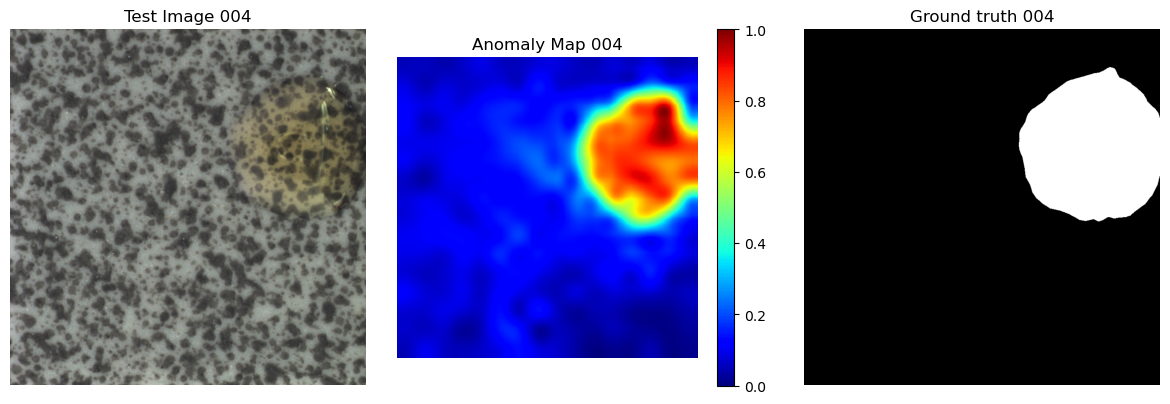

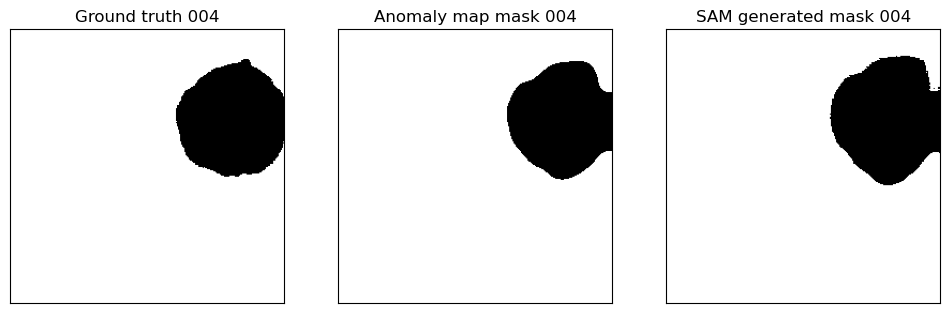

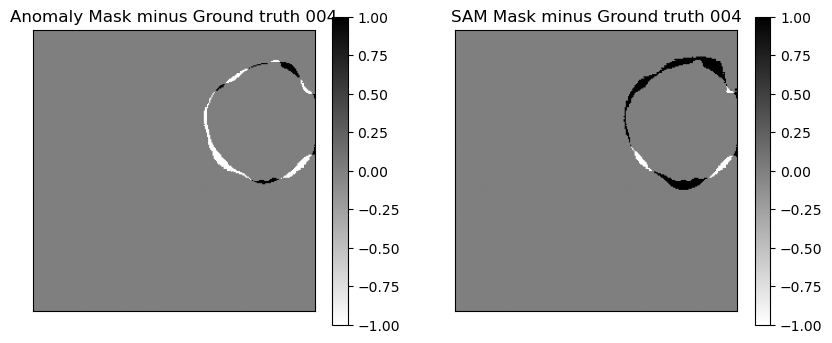

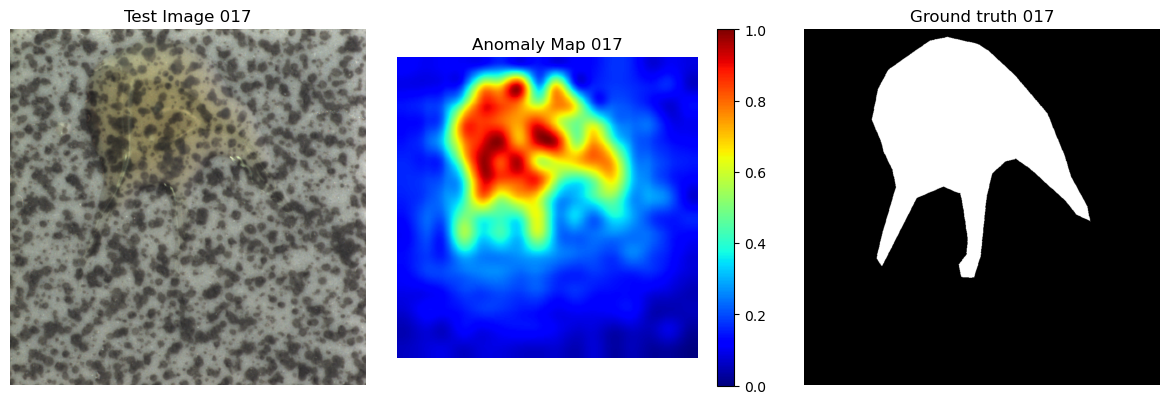

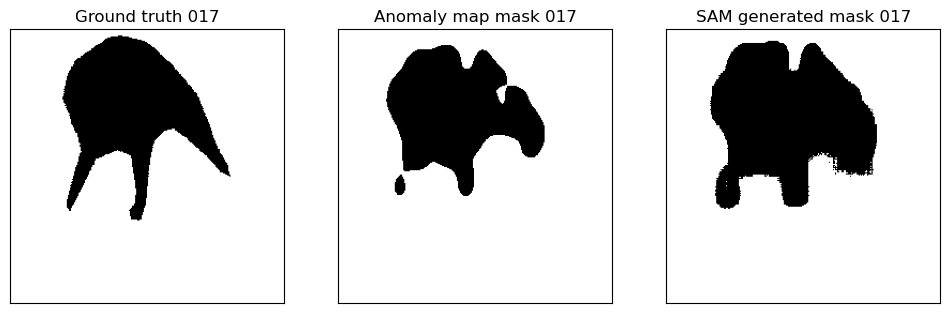

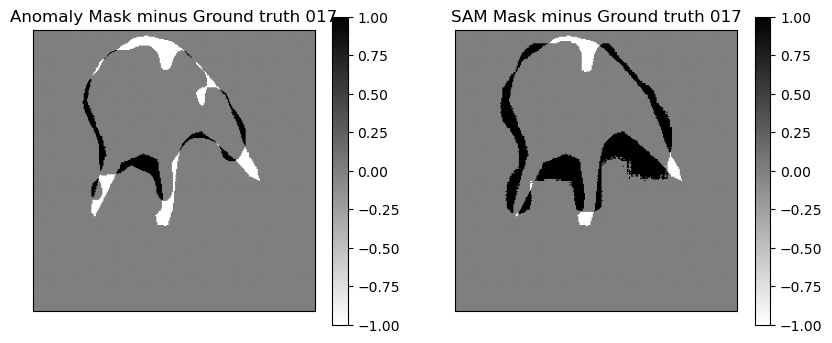

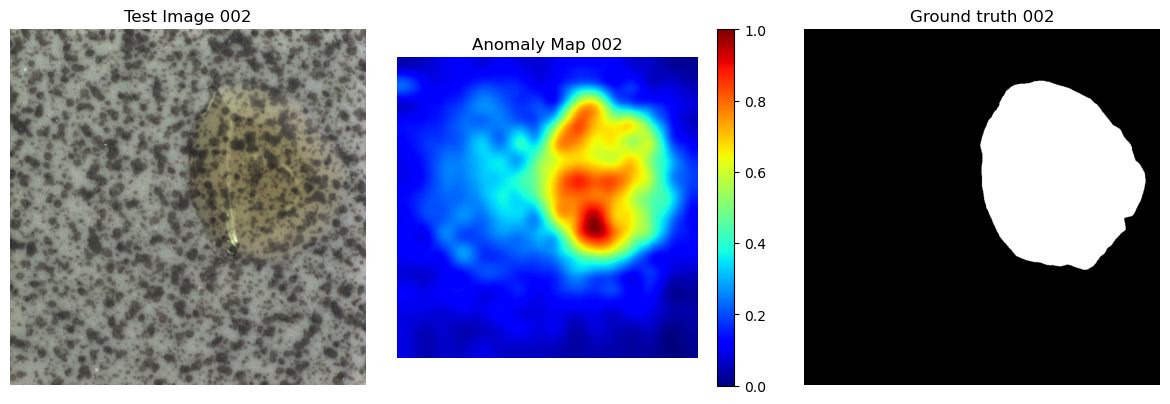

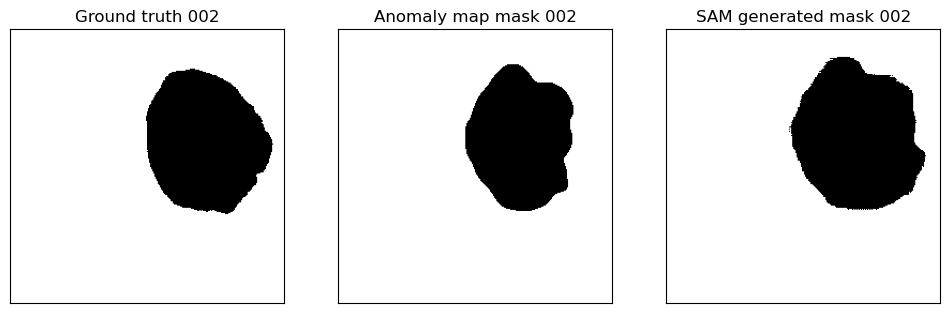

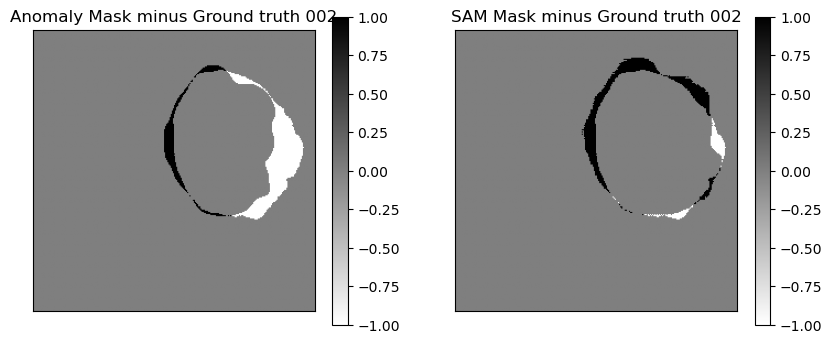

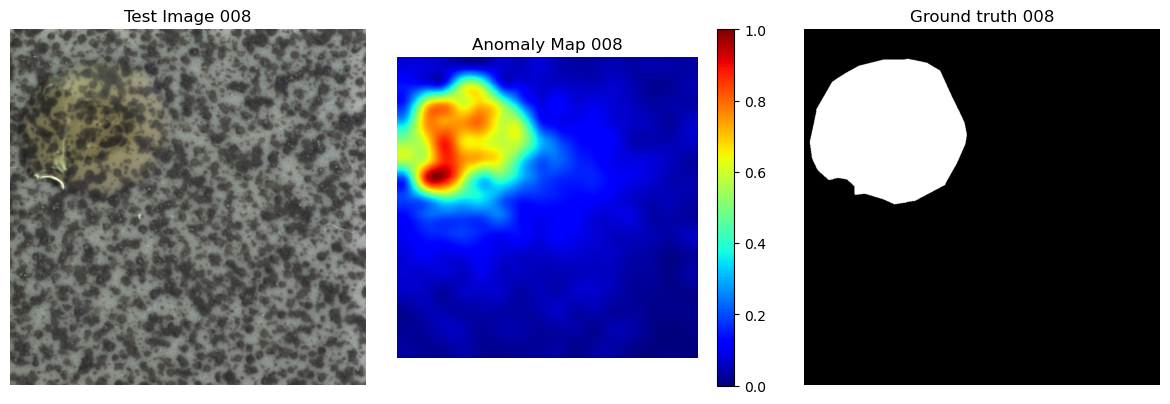

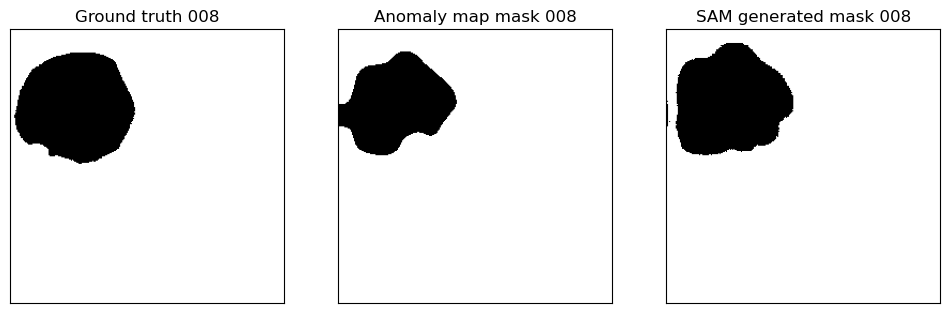

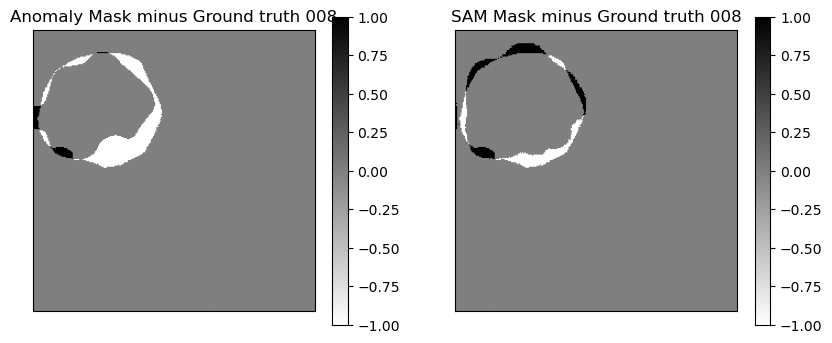

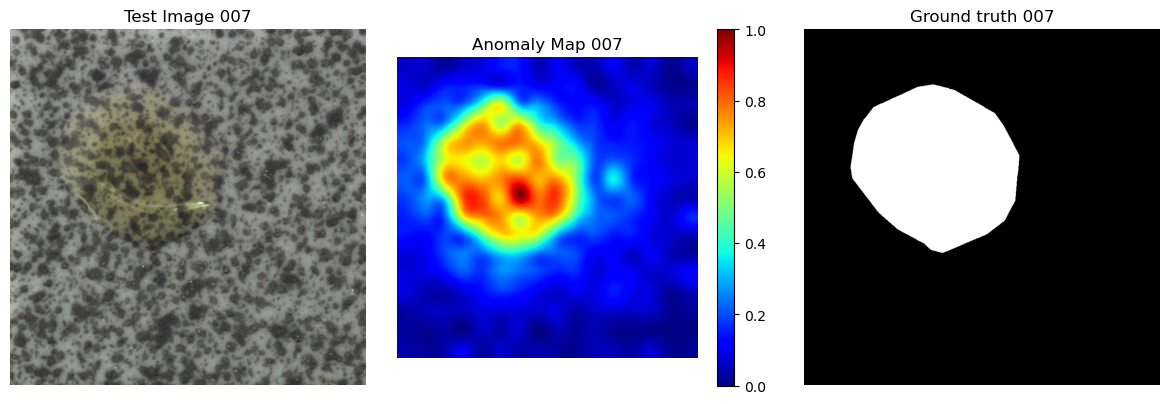

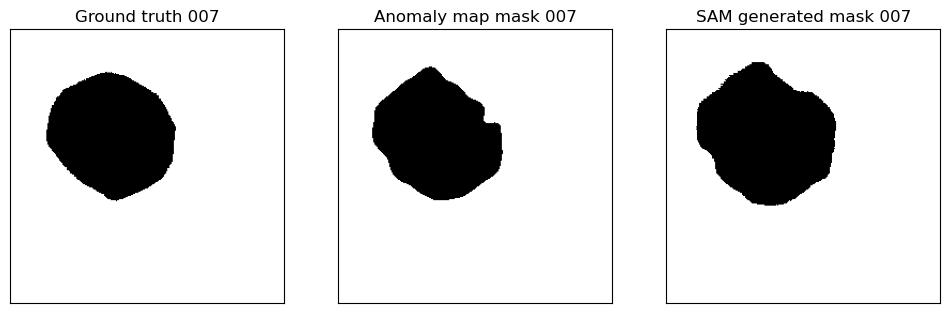

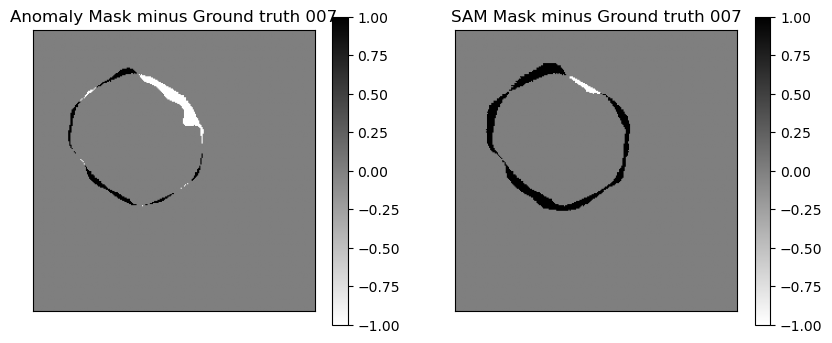

tile_oil_004 Dice overlap for Ground Truth and Anomaly Map mask:  0.9453091532200486
tile_oil_004 Dice overlap for Ground Truth and SAM mask:          0.9133149919210446
tile_oil_017 Dice overlap for Ground Truth and Anomaly Map mask:  0.9453091532200486
tile_oil_017 Dice overlap for Ground Truth and SAM mask:          0.9133149919210446
tile_oil_002 Dice overlap for Ground Truth and Anomaly Map mask:  0.9453091532200486
tile_oil_002 Dice overlap for Ground Truth and SAM mask:          0.9133149919210446
tile_oil_008 Dice overlap for Ground Truth and Anomaly Map mask:  0.9453091532200486
tile_oil_008 Dice overlap for Ground Truth and SAM mask:          0.9133149919210446
tile_oil_007 Dice overlap for Ground Truth and Anomaly Map mask:  0.9453091532200486
tile_oil_007 Dice overlap for Ground Truth and SAM mask:          0.9133149919210446
Average Dice Overlap score for Anomaly maps in tile/oil:  0.8978101960224967
Average Dice Overlap score for SAM mask map in tile/oil:  0.8967092746568

In [ ]:
DATA_DIR = "mvtec_anomaly_detection/"
category = "tile"
anomaly = "oil"
use_test_image_num = False # set to True to set num_to_show equal to all the test images 
num_to_show = 5

show_images = True

# --- Load images ---
train_folder = DATA_DIR + f"{category}/train/good"
test_folder = DATA_DIR + f"{category}/test/{anomaly}"
ground_truth_folder = DATA_DIR + f"{category}/ground_truth/{anomaly}"

train_image_paths = sorted(glob.glob(train_folder + "/*.png"))
test_image_paths = sorted(glob.glob(test_folder + "/*.png"))
ground_truth_paths = sorted(glob.glob(ground_truth_folder + "/*.png"))

# Load images into PIL lists
Train_Images = [Image.open(p).convert("RGB") for p in train_image_paths]
Test_Images = [Image.open(p).convert("RGB") for p in test_image_paths]
Truth_Images = [Image.open(p).convert("RGB") for p in ground_truth_paths]

# --- Initialize your model ---
model.eval()

# --- Initialize anomaly calculator ---
anomaly_calculator = Calculate_Anomaly_And_Mask(model, Train_Images, Test_Images)

# anomaly_calculator.rescale_factor = 3.28
# anomaly_calculator.rescale_training = True
# anomaly_calculator.rescale_test = True

# --- Compute anomaly maps ---
Anomaly_Maps = anomaly_calculator.Compute_Anomaly_Mask7()  # shape [num_test, 256, 256]


# --- Visualize some random test images with their anomaly maps ---
if (use_test_image_num==True):
    num_to_show = len(Test_Images)
indices = random.sample(range(len(Test_Images)), num_to_show)


anomaly_map_dice_overlaps = []
SAM_mask_dice_overlaps = []


for i, idx in enumerate(indices):
    anomaly_map_unnorm = Anomaly_Maps[idx]

    # Normalizing anomaly map
    anomaly_map = (anomaly_map_unnorm - anomaly_map_unnorm.min()) / (anomaly_map_unnorm.max() - anomaly_map_unnorm.min()) * 255
    anomaly_map = anomaly_map.astype(np.uint8)
    cv2.imwrite(f"results/{category}_{anomaly}_{str(idx).zfill(3)}_anomaly_map.png", anomaly_map)

    # Creating a simple mask where >= 0.5 intensity is marked as an anomaly
    anomaly_map_mask = np.where(anomaly_map >= 0.5 * 255, 1.0, 0.0)
    anomaly_map_mask = anomaly_map_mask.astype(int)
    cv2.imwrite(f"results/{category}_{anomaly}_{str(idx).zfill(3)}_anomaly_map_mask.png", anomaly_map_mask)


    ground_truth_path = DATA_DIR + f"{category}/ground_truth/{anomaly}/{str(idx).zfill(3)}_mask.png"
    ground_truth = cv2.imread(ground_truth_path)

    # Resizing ground truth to 256 x 256
    ground_truth = cv2.resize(ground_truth, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)[:, :, 1]
    ground_truth = (ground_truth - ground_truth.min()) / (ground_truth.max() - ground_truth.min())
    ground_truth = ground_truth.astype(int)

    # Finding local peaks for SAM Mask
    image_coords = cv2.imread(f"results/{category}_{anomaly}_{str(idx).zfill(3)}_anomaly_map.png", cv2.IMREAD_GRAYSCALE)
    im = img_as_float(image_coords)
    image_max = ndi.maximum_filter(im, size=20, mode='constant')
    # Comparison between image_max and im to find the coordinates of local maxima
    coordinates = peak_local_max(im, min_distance=20, threshold_rel=0.7)
    # print("Coordinates of local maxima:")
    # print(coordinates)  # Each row is (row, col) of a local maximum

    # Create SAM model
    sam_checkpoint = "sam_vit_b_01ec64.pth"
    model_type = "vit_b"
    device = "cuda"
    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
    sam.to(device=device)


    image = cv2.imread(f"results/{category}_{anomaly}_{str(idx).zfill(3)}_anomaly_map.png")
    # coordinates_copy = coordinates.copy()
    coordinates_flip = np.flip(coordinates, 1) # Flip to make coordinates make sense
    # print(coordinates_copy)
    predictor = SamPredictor(sam)
    predictor.set_image(image)
    input_point = coordinates_flip
    input_label = np.ones(len(input_point))

    # Create SAM mask
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=False,
    )

    # Save SAM mask. 
    SAM_mask = masks[0].astype(int)
    cv2.imwrite(f"results/{category}_{anomaly}_{str(idx).zfill(3)}_SAM_mask.png", SAM_mask)

    # Calculating Dice overlap scores
    anomaly_dice_overlap = f1_score(ground_truth.flatten(), anomaly_map_mask.flatten())
    SAM_dice_overlap = f1_score(ground_truth.flatten(), SAM_mask.flatten())
    anomaly_map_dice_overlaps.append(anomaly_dice_overlap)
    SAM_mask_dice_overlaps.append(SAM_dice_overlap)



    if (show_images==False):
        pass

    else:
        plt.figure(figsize=(12, 4))
        test_img = Test_Images[idx]
        ground_truth_image = Truth_Images[idx]
        
        # Show test image
        plt.subplot(1, 3, 1)
        plt.imshow(test_img)
        plt.title(f"Test Image {str(idx).zfill(3)}")
        plt.axis('off')

        # Show anomaly map
        plt.subplot(1, 3, 2)
        plt.imshow(anomaly_map_unnorm, cmap='jet', vmin = 0, vmax = 1)
        plt.title(f"Anomaly Map {str(idx).zfill(3)}")
        plt.axis('off')
        plt.colorbar()

        # Show ground truth
        plt.subplot(1, 3, 3)
        plt.imshow(ground_truth_image, cmap='binary')
        plt.title(f"Ground truth {str(idx).zfill(3)}")
        plt.axis('off')

        plt.tight_layout()
        plt.show()


        # Individual masks and Ground Truth
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(ground_truth, cmap="binary")
        plt.title(f"Ground truth {str(idx).zfill(3)}")
        # plt.axis("off")
        plt.yticks([])
        plt.xticks([])
        # plt.colorbar()
        plt.subplot(1, 3, 2)
        plt.imshow(anomaly_map_mask, cmap="binary")
        plt.title(f"Anomaly map mask {str(idx).zfill(3)}")
        # plt.axis("off")
        plt.yticks([])
        plt.xticks([])
        # plt.colorbar()
        plt.subplot(1, 3, 3)
        plt.imshow(SAM_mask, cmap="binary")
        plt.title(f"SAM generated mask {str(idx).zfill(3)}")
        # plt.axis("off")
        plt.yticks([])
        plt.xticks([])
        # plt.colorbar()
        plt.show()

        # Masks minus Ground Truth
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(anomaly_map_mask - ground_truth, cmap="binary")
        plt.title(f"Anomaly Mask minus Ground truth {str(idx).zfill(3)}")
        plt.yticks([])
        plt.xticks([])
        plt.colorbar()
        plt.subplot(1, 2, 2)
        plt.imshow(SAM_mask - ground_truth, cmap="binary")
        plt.title(f"SAM Mask minus Ground truth {str(idx).zfill(3)}")
        plt.yticks([])
        plt.xticks([])
        plt.colorbar()
        plt.show()

for idx in indices:
    print(f"{category}_{anomaly}_{str(idx).zfill(3)} Dice overlap for Ground Truth and Anomaly Map mask: ", anomaly_dice_overlap)
    print(f"{category}_{anomaly}_{str(idx).zfill(3)} Dice overlap for Ground Truth and SAM mask:         ", SAM_dice_overlap)

mean_anomaly_dice_overlap = sum(anomaly_map_dice_overlaps) / len(anomaly_map_dice_overlaps)
mean_SAM_dice_overlap = sum(SAM_mask_dice_overlaps) / len(SAM_mask_dice_overlaps)
print(f"Average Dice Overlap score for Anomaly maps in {category}/{anomaly}: ", mean_anomaly_dice_overlap)
print(f"Average Dice Overlap score for SAM mask map in {category}/{anomaly}: ", mean_SAM_dice_overlap)

tile_oil_001 Dice overlap for Ground Truth and Anomaly Map mask:  0.9319517663455129
tile_oil_001 Dice overlap for Ground Truth and SAM mask:          0.13178726725387446


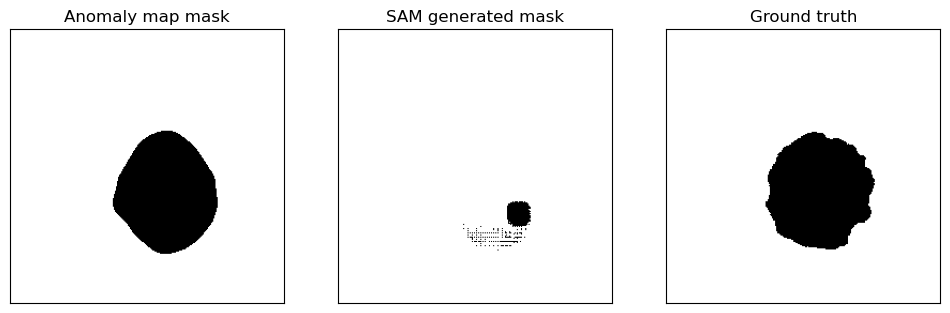

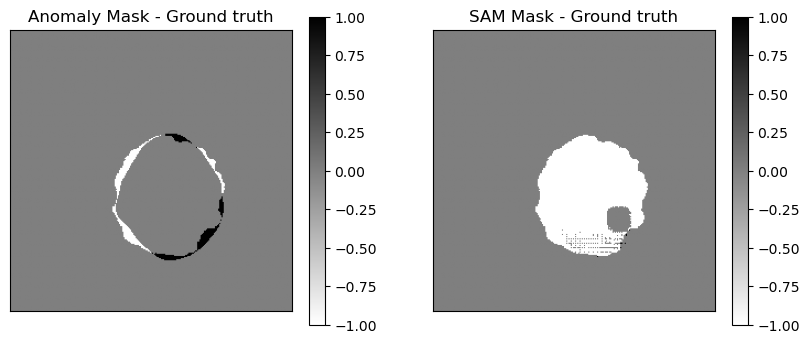

In [5]:
# To check individual anomalies

category = "tile"
anomaly = "oil"
idx = 1

anomaly_map_mask_to_show = cv2.imread(f"results/{category}_{anomaly}_{str(idx).zfill(3)}_anomaly_map_mask.png", cv2.IMREAD_GRAYSCALE)
SAM_mask_to_show = cv2.imread(f"results/{category}_{anomaly}_{str(idx).zfill(3)}_SAM_mask.png", cv2.IMREAD_GRAYSCALE)
ground_truth_path = DATA_DIR + f"{category}/ground_truth/{anomaly}/{str(idx).zfill(3)}_mask.png"
ground_truth = cv2.imread(ground_truth_path)
# Resizing ground truth to 256 x 256
ground_truth = cv2.resize(ground_truth, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)[:, :, 1]
ground_truth = (ground_truth - ground_truth.min()) / (ground_truth.max() - ground_truth.min())
ground_truth_to_show = ground_truth.astype(int)

anomaly_dice_overlap = f1_score(ground_truth_to_show.flatten(), anomaly_map_mask_to_show.flatten())
SAM_dice_overlap = f1_score(ground_truth_to_show.flatten(), SAM_mask_to_show.flatten())
print(f"{category}_{anomaly}_{str(idx).zfill(3)} Dice overlap for Ground Truth and Anomaly Map mask: ", anomaly_dice_overlap)
print(f"{category}_{anomaly}_{str(idx).zfill(3)} Dice overlap for Ground Truth and SAM mask:         ", SAM_dice_overlap)


# Individual masks and Ground Truth
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(anomaly_map_mask_to_show, cmap="binary")
plt.title("Anomaly map mask")
# plt.axis("off")
plt.yticks([])
plt.xticks([])
# plt.colorbar()
plt.subplot(1, 3, 2)
plt.imshow(SAM_mask_to_show, cmap="binary")
plt.title("SAM generated mask")
# plt.axis("off")
plt.yticks([])
plt.xticks([])
# plt.colorbar()
plt.subplot(1, 3, 3)
plt.imshow(ground_truth_to_show, cmap="binary")
plt.title("Ground truth")
# plt.axis("off")
plt.yticks([])
plt.xticks([])
# plt.colorbar()
plt.show


# Masks minus Ground Truth
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(anomaly_map_mask_to_show - ground_truth_to_show, cmap="binary")
plt.title("Anomaly Mask - Ground truth")
plt.yticks([])
plt.xticks([])
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(SAM_mask_to_show - ground_truth_to_show, cmap="binary")
plt.title("SAM Mask - Ground truth")
plt.yticks([])
plt.xticks([])
plt.colorbar()